# Notebook for analyzing data from our S-index validation work using 49M+ real world datasets

## Import

In [9]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.colors import to_rgba

In [10]:
import seaborn as sns
sns.set(
    style="ticks",
    font="DejaVu Sans",
    rc={
        # Typography
        "font.size": 10,          
        "axes.titlesize": 16,     
        "axes.titleweight": "bold",
        "axes.labelsize": 14,      
        "xtick.labelsize": 12,     
        "ytick.labelsize": 12,
        "legend.fontsize": 10,
        
        # Spines and Ticks
        "axes.spines.top": False,    
        "axes.spines.right": False,  
        "axes.linewidth": 0.8,      
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.direction": "out", 
        "ytick.direction": "out",
    }
)
# Wong Palette (optimized for color-blindness)
color_palette = [
    '#009E73', # Green
    '#0072B2', # Blue
    '#D55E00', # Vermillion (Orange-Red)
    '#56B4E9', # Sky Blue
    '#F0E442', # Yellow
    '#CC79A7'  # Reddish Purple
]
sns.set_palette(color_palette)

## DuckDB database file path

In [13]:
# See README for instructions to download this file
dataset_db = r"C:\Users\BPatel\Documents\dataset_index\dataset_reports.duckdb"

## Overview of data collected

### Datasets Used

Overview of the datasetes used for our real world validation

#### Preview table

In [15]:
con = duckdb.connect(dataset_db)

query = """
SELECT *
FROM metadata
limit 3
"""

display(con.execute(query).df())
con.close()

,dataset_id,pub_ts,pubyear,creators,title,source
0,10.15156/bio/sh3578074.08fu,2021-01-01,2021,"[{""name"":""Kõljalg, Urmas"",""name_type"":""Persona...",SH3578074.08FU,datacite
1,10.15156/bio/sh3578075.08fu,2021-01-01,2021,"[{""name"":""Kõljalg, Urmas"",""name_type"":""Persona...",SH3578075.08FU,datacite
2,10.5281/zenodo.5152863,2021-01-01,2021,"[{""name"":""Roth, Marco Pascal"",""identifiers"":[""...",Seismicity catalog of hydraulic-fracturing-ind...,datacite


#### Number of datasets

In [16]:
# Data
con = duckdb.connect(dataset_db)

query = """
SELECT 
    COALESCE(source, 'Total') AS source,
    COUNT(*) AS dataset_count
FROM metadata
GROUP BY ROLLUP(source)
ORDER BY (source IS NULL) ASC, dataset_count DESC;
"""

df_dataset_source = con.execute(query).df()
con.close()

# Display
print("Number of datasets by source:")
display(df_dataset_source.style.format({'dataset_count': '{:,}'}))

Number of datasets by source:


,source,dataset_count
0,datacite,"49,009,522"
1,emdb,"51,645"
2,Total,"49,061,167"


#### Distribution of datasets by publication years

In [17]:
# Data
con = duckdb.connect(dataset_db)

query = """
SELECT 
    pubyear, 
    COUNT(*) AS dataset_count
FROM metadata
WHERE pubyear IS NOT NULL
GROUP BY pubyear
ORDER BY pubyear
"""

df_dataset_pub_year = con.execute(query).df()
con.close()
display(df_dataset_pub_year.head())

,pubyear,dataset_count
0,1950,97
1,1951,96
2,1952,103
3,1953,349
4,1954,309


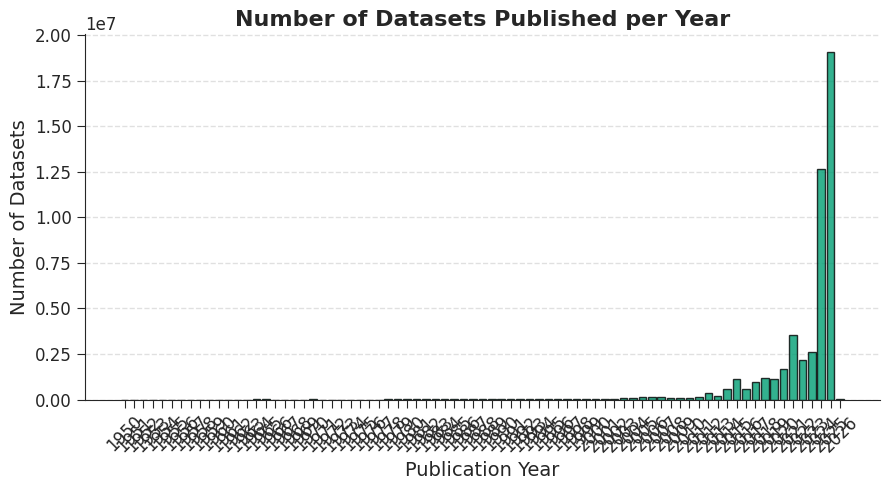

In [18]:
# Plot dataset count vs publication year
plt.figure(figsize=(9, 5))
plt.bar(df_dataset_pub_year['pubyear'].astype(str), df_dataset_pub_year['dataset_count'], color=color_palette[0], edgecolor='black', alpha=0.8)

# Formatting
plt.title('Number of Datasets Published per Year')
plt.xlabel('Publication Year')
plt.ylabel('Number of Datasets')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Save
plt.tight_layout()
plt.savefig('output/dataset_count_by_pubyear.png', dpi=300)

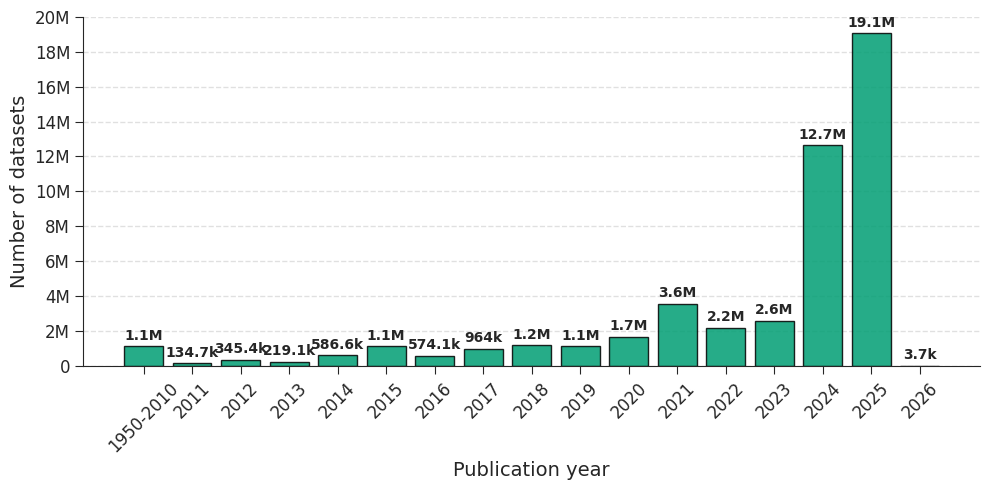

In [19]:
# Plot dataset count vs pubyear regroup 1950 to 2010 count
df_dataset_pub_year['year_bucket'] = np.where(df_dataset_pub_year['pubyear'] <= 2010, '1950-2010', df_dataset_pub_year['pubyear'].astype(str))
plot_df = df_dataset_pub_year.groupby('year_bucket').agg({'dataset_count': 'sum', 'pubyear': 'min'}).sort_values('pubyear').reset_index()
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(plot_df['year_bucket'], plot_df['dataset_count'], color=color_palette[0], edgecolor='black', alpha=0.85)

# Formatting
ax.set_ylabel('Number of datasets')
ax.set_xlabel('Publication year')

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)


# Helper function to format bar label numbers (like 138000 -> 138k)
def format_k_m(value):
    if value >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'.replace('.0M', 'M')
    elif value >= 1_000:
        return f'{value / 1_000:.1f}k'.replace('.0k', 'k')
    return str(int(value))
    
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (ax.get_ylim()[1] * 0.01),
            format_k_m(height), ha='center', va='bottom', fontweight='bold')

# Format y axis labels to show M (more clean)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1e6)}M' if x != 0 else '0'))
ax.set_yticks(np.arange(0, 21_000_000, 2_000_000))
ax.set_ylim(0, 20_000_000)

sns.despine()

# Save
plt.tight_layout()
plt.savefig('output/dataset_count_by_pubyear_grouping.png', dpi=300)
plt.show()

### Citations

Overview of the citations identified for our datasets

#### Preview table

In [20]:
con = duckdb.connect(dataset_db)

query = """
SELECT *
FROM citations
limit 3
"""

display(con.execute(query).df())
con.close()

,dataset_id,cit_ts,citation_year,citation_weight,source
0,10.1594/ieda/100002,2008-06-01,2008,1.00,"[""mdc""]"
1,10.1594/ieda/100004,2010-01-01,2010,1.00,"[""mdc""]"
2,10.5524/100001,2011-08-25,2011,1.00,"[""mdc""]"


#### Number of citations by source

In [21]:
con = duckdb.connect(dataset_db)
query = """
SELECT * FROM (
    SELECT 
        source, 
        COUNT(*) as citation_count
    FROM (
        SELECT unnest(CAST(source AS VARCHAR[])) as source 
        FROM citations
    ) 
    GROUP BY source

    UNION ALL

    SELECT 
        'unique' as source, 
        COUNT(*) as citation_count
    FROM citations
) AS combined_results

ORDER BY (source = 'unique') ASC, citation_count DESC
"""
df_citations_source = con.execute(query).df()
display(df_citations_source.style.format({'citation_count': '{:,}'}))
con.close()

,source,citation_count
0,mdc,"5,118,664"
1,openalex,"2,754,157"
2,unique,"7,669,263"


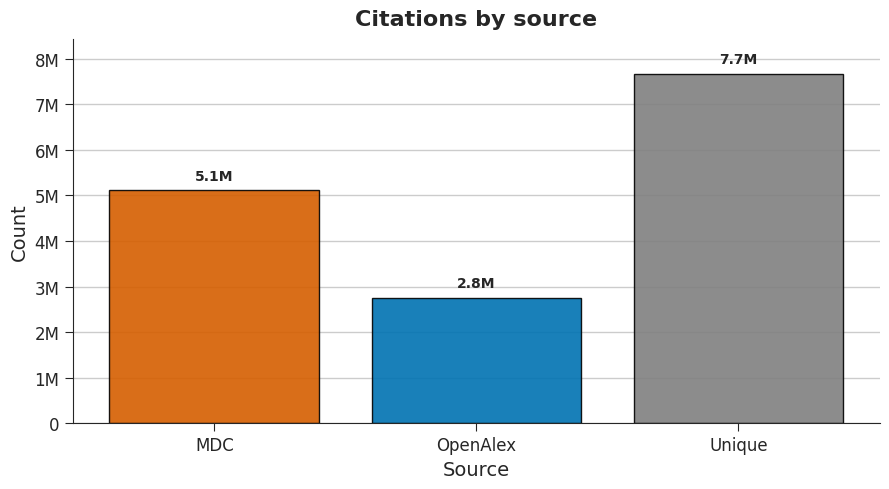

In [22]:
# Plot
label_mapping = {
    'datacite': 'Datacite',
    'openalex': 'OpenAlex',
    'mdc': 'MDC',
    'unique': 'Unique'
}
df_citations_source['source'] = df_citations_source['source'].replace(label_mapping)

color_map = {
    'Datacite': color_palette[0],
    'OpenAlex': color_palette[1],
    'MDC': color_palette[2],
    'Unique': "grey"
}
colors = [color_map[source] for source in df_citations_source['source']]

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(
    df_citations_source['source'], 
    df_citations_source['citation_count'], 
    color=colors, 
    edgecolor='black', 
    alpha=0.9
)

# Format
ax.set_title('Citations by source', pad=10)
ax.set_ylabel('Count')
ax.set_xlabel('Source')
ax.set_axisbelow(True)
ax.grid(axis='y') 

# Y axis format (0, 1M, 2M, etc.)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'.replace('.0M', 'M') if x >= 1e6 else f'{int(x)}')
)

# Numbers on bar (with k, M format)
def format_k_m(value):
    if value >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'.replace('.0M', 'M')
    elif value >= 1_000:
        return f'{value / 1_000:.1f}k'.replace('.0k', 'k')
    return str(int(value))

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + (ax.get_ylim()[1] * 0.02), 
        format_k_m(height), 
        ha='center', 
        va='bottom', 
        fontweight='bold'
    )
ax.set_ylim(0, df_citations_source['citation_count'].max() * 1.1)

sns.despine()

# Save
plt.tight_layout()
plt.savefig('output/citations_source.png', dpi=300)
plt.show()

### Mentions

Overview of the mentions identified for our datasets

#### Preview table

In [23]:
con = duckdb.connect(dataset_db)

query = """
SELECT *
FROM mentions
WHERE mention_weight>1.0
limit 3
"""

display(con.execute(query).df())
con.close()

,dataset_id,men_ts,mention_year,mention_weight,source
0,10.57967/hf/0737,2024-03-11,2024,1.23,"[""hf""]"
1,10.57967/hf/0737,2024-05-18,2024,1.23,"[""hf""]"
2,10.57967/hf/0737,2024-07-12,2024,1.23,"[""hf""]"


#### Number of mentions by source

In [24]:
con = duckdb.connect(dataset_db)
query = """
SELECT * FROM (
    SELECT 
        source, 
        COUNT(*) as mention_count
    FROM (
        SELECT unnest(CAST(source AS VARCHAR[])) as source 
        FROM mentions
    ) 
    GROUP BY source

    UNION ALL

    SELECT 
        'unique' as source, 
        COUNT(*) as mention_count
    FROM mentions
) AS combined_results

ORDER BY (source = 'unique') ASC, mention_count DESC
"""
df_mentions_source = con.execute(query).df()
display(df_mentions_source.style.format({'mention_count': '{:,}'}))
con.close()

,source,mention_count
0,swh,"41,528"
1,hf,"5,243"
2,unique,"46,771"


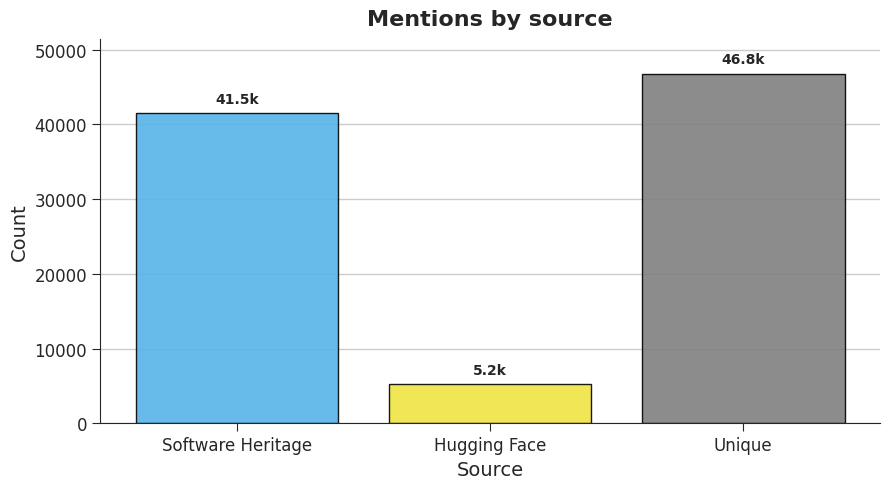

In [25]:
# Plot
label_mapping = {
    'swh': 'Software Heritage',
    'hf': 'Hugging Face',
    'unique': 'Unique'
}
df_mentions_source['source'] = df_mentions_source['source'].replace(label_mapping)

color_map = {
    'Software Heritage': color_palette[3],
    'Hugging Face': color_palette[4],
    'Unique': "grey"
}
colors = [color_map[source] for source in df_mentions_source['source']]

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(
    df_mentions_source['source'], 
    df_mentions_source['mention_count'], 
    color=colors, 
    edgecolor='black', 
    alpha=0.9
)

# Format
ax.set_title('Mentions by source', pad=10)
ax.set_ylabel('Count')
ax.set_xlabel('Source')
ax.set_axisbelow(True)
ax.grid(axis='y') 

# Y axis format (0, 1M, 2M, etc.)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'.replace('.0M', 'M') if x >= 1e6 else f'{int(x)}')
)

# Numbers on bar (with k, M format)
def format_k_m(value):
    if value >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'.replace('.0M', 'M')
    elif value >= 1_000:
        return f'{value / 1_000:.1f}k'.replace('.0k', 'k')
    return str(int(value))

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + (ax.get_ylim()[1] * 0.02),
        format_k_m(height), 
        ha='center', 
        va='bottom', 
        fontweight='bold'
    )
ax.set_ylim(0, df_mentions_source['mention_count'].max() * 1.1)

sns.despine()

# Save
plt.tight_layout()
plt.savefig('output/mentions_source.png', dpi=300)
plt.show()

## Research fields

Overview of the research fields assigned using the OpenAlex taxonomy

### Preview table

In [26]:
con = duckdb.connect(dataset_db)
query = """
SELECT *
FROM topics
limit 3
"""

display(con.execute(query).df())
con.close()

,dataset_id,topic_id,topic_name,score,source,subfield_id,subfield_name,field_id,field_name,domain_id,domain_name
0,10.5287/bodleian6zr1.2,T12375,Cuban History and Society,0.24,custom_model,3312,Sociology and Political Science,33,Social Sciences,2,Social Sciences
1,10.5287/bodleian8irf.2,T11803,Superconducting and THz Device Technology,0.25,custom_model,3103,Astronomy and Astrophysics,31,Physics and Astronomy,3,Physical Sciences
2,10.5287/bodleian2pyz.2,T12860,Family and Patient Care in Intensive Care Units,0.28,custom_model,3614,Radiological and Ultrasound Technology,36,Health Professions,4,Health Sciences


In [51]:
con = duckdb.connect(dataset_db)
query = """
SELECT *
FROM topics
WHERE (topic_id IS NULL AND source='openalex')
LIMIT 3
"""
df = con.execute(query).df()
display(df)

,dataset_id,topic_id,topic_name,score,source,subfield_id,subfield_name,field_id,field_name,domain_id,domain_name
0,10.5287/bodleiandi89.2,T11150,Endoplasmic Reticulum Stress and Disease,0.73,openalex,1307,Cell Biology,13,"Biochemistry, Genetics and Molecular Biology",1,Life Sciences
1,10.5287/bodleiannfy.2,T10513,Natural Fiber Reinforced Composites,0.25,openalex,2507,Polymers and Plastics,25,Materials Science,3,Physical Sciences
2,10.5287/bodleian8otp.2,T10521,RNA and protein synthesis mechanisms,0.24,openalex,1312,Molecular Biology,13,"Biochemistry, Genetics and Molecular Biology",1,Life Sciences


### Topics source

In [53]:
# Total from OpenAlex and custom model
con = duckdb.connect(dataset_db)
# Querying both Non-Null and Null counts at once
query_oa = """
SELECT 
    COUNT(topic_id) AS non_null, 
    COUNT(*) FILTER (WHERE topic_id IS NULL) AS total_null 
FROM topics_oa
"""

query_c = """
SELECT 
    COUNT(topic_id) AS non_null, 
    COUNT(*) FILTER (WHERE topic_id IS NULL) AS total_null 
FROM topics_custom_model
"""

# Fetch results
res_oa = con.execute(query_oa).fetchone()
res_c = con.execute(query_c).fetchone()

print(f"OpenAlex - Assigned: {res_oa[0]:,}, Non-assigned: {res_oa[1]:,}")
print(f"Custom Model - Assigned: {res_c[0]:,}, Non-assigned: {res_c[1]:,}")
con.close()

OpenAlex - Assigned: 15,324,819, Non-assigned: 0
Custom Model - Assigned: 49,035,606, Non-assigned: 25,561


In [80]:
# Total after merge logic (OpenAlex if score>0.5 else better of the two)
con = duckdb.connect(dataset_db)
query = """
    SELECT 
        CASE 
            WHEN GROUPING(display_source) = 1 THEN 'Total'
            ELSE display_source 
        END as source,
        COUNT(*) as count
    FROM (
        SELECT 
            CASE 
                WHEN topic_id IS NULL THEN 'not_assigned' 
                ELSE source 
            END as display_source
        FROM topics
    )
    GROUP BY ROLLUP(display_source)
    ORDER BY GROUPING(display_source) ASC, count DESC
"""
df_topics_source = con.sql(query).df()
display(df_topics_source.style.format({'count': '{:,}'}))
con.close()

,source,count
0,custom_model,"41,650,357"
1,openalex,"7,394,117"
2,not_assigned,"16,693"
3,Total,"49,061,167"


,source,count
0,Custom model,41650357
1,OpenAlex,7394117
2,None,16693
3,Total,49061167


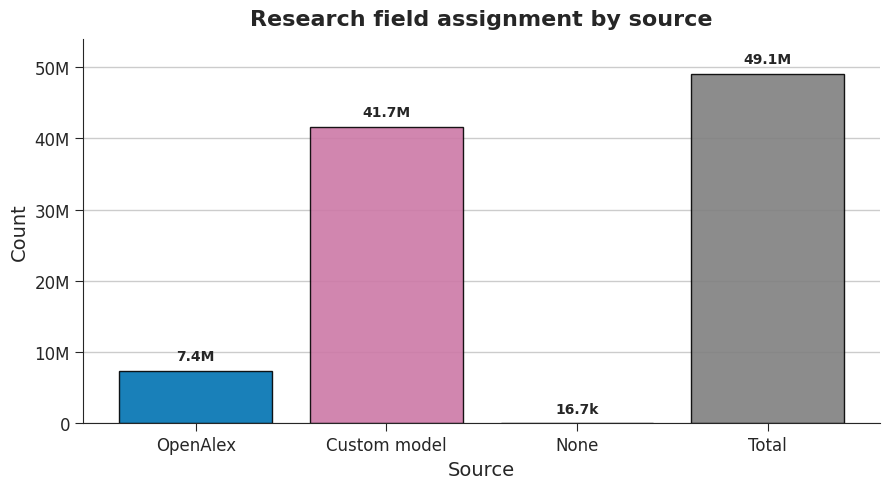

In [81]:
# Plot
label_mapping = {
    'openalex': 'OpenAlex',
    'custom_model': 'Custom model',
    'not_assigned': 'None'
}
df_topics_source['source'] = df_topics_source['source'].replace(label_mapping)
display(df_topics_source)
desired_order = ['OpenAlex', 'Custom model', 'None', 'Total']
df_topics_source['source'] = pd.Categorical(df_topics_source['source'], categories=desired_order, ordered=True)
df_topics_source = df_topics_source.sort_values('source')

color_map = {
    'OpenAlex': color_palette[1],
    'Custom model': color_palette[5],
    'None': 'lightgrey',
    'Total': 'grey'
}
colors = [color_map[source] for source in df_topics_source['source']]


fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(
    df_topics_source['source'], 
    df_topics_source['count'], 
    color=colors, 
    edgecolor='black', 
    alpha=0.9
)

# Format
ax.set_title('Research field assignment by source', pad=10)
ax.set_ylabel('Count')
ax.set_xlabel('Source')
ax.set_axisbelow(True)
ax.grid(axis='y') 

# Y axis format (0, 1M, 2M, etc.)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'.replace('.0M', 'M') if x >= 1e6 else f'{int(x)}')
)

# Numbers on bar (with k, M format)
def format_k_m(value):
    if value >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'.replace('.0M', 'M')
    elif value >= 1_000:
        return f'{value / 1_000:.1f}k'.replace('.0k', 'k')
    return str(int(value))

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + (ax.get_ylim()[1] * 0.02),
        format_k_m(height), 
        ha='center', 
        va='bottom', 
        fontweight='bold'
    )
ax.set_ylim(0, df_topics_source['count'].max() * 1.1)

sns.despine()

# Save
plt.tight_layout()
plt.savefig('output/research_field_source.png', dpi=300)
plt.show()

### Combined plot

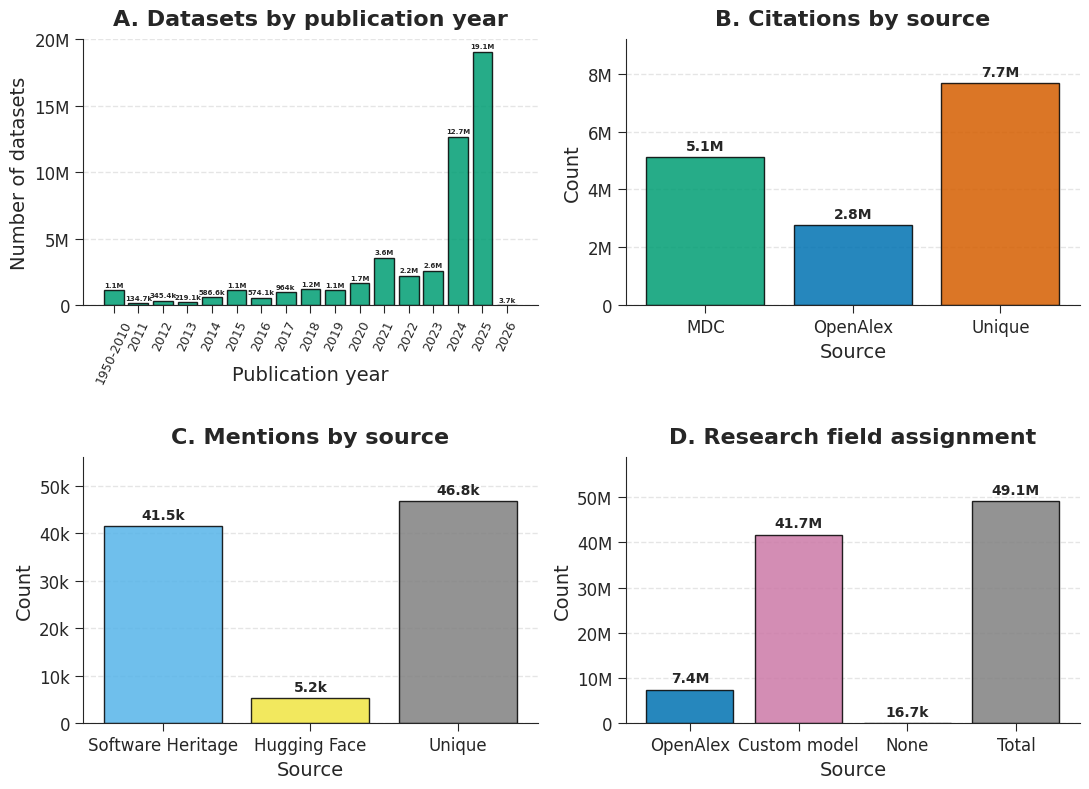

In [119]:
# Helper Functions
def format_k_m(value):
    if value >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'.replace('.0M', 'M')
    elif value >= 1_000:
        return f'{value / 1_000:.1f}k'.replace('.0k', 'k')
    return str(int(value))

def style_subplot(ax, title, xlabel, ylabel="Count"):
    ax.set_title(title, fontweight='bold', pad=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format_k_m(x)))
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    sns.despine(ax=ax)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(11, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

## TOP LEFT: Datasets by publication Year
ax1 = axes[0, 0]
df_dataset_pub_year['year_bucket'] = np.where(df_dataset_pub_year['pubyear'] <= 2010, '1950-2010', df_dataset_pub_year['pubyear'].astype(str))
plot_df = df_dataset_pub_year.groupby('year_bucket').agg({'dataset_count': 'sum', 'pubyear': 'min'}).sort_values('pubyear').reset_index()

bars1 = ax1.bar(plot_df['year_bucket'], plot_df['dataset_count'], color=color_palette[0], edgecolor='black', alpha=0.85)
style_subplot(ax1, "A. Datasets by publication year", "Publication year", "Number of datasets")
ax1.tick_params(axis='x', labelsize=9, rotation=65)
ax1.set_xlabel("Publication year", labelpad=-15)

# 2. TOP RIGHT: Citations by source
ax2 = axes[0, 1]
map2 = {'datacite': 'Datacite', 'openalex': 'OpenAlex', 'mdc': 'MDC', 'unique': 'Unique'}
df_citations_source['source'] = df_citations_source['source'].replace(map2)
colors2 = [color_palette[0], color_palette[1], color_palette[2], "grey"]

bars2 = ax2.bar(df_citations_source['source'], df_citations_source['citation_count'], color=colors2, edgecolor='black', alpha=0.85)
style_subplot(ax2, "B. Citations by source", "Source")

# 3. BOTTOM LEFT: Mentions by source
ax3 = axes[1, 0]
map3 = {'swh': 'Software Heritage', 'huggingface': 'Hugging Face', 'unique': 'Unique'}
df_mentions_source['source'] = df_mentions_source['source'].replace(map3)
colors3 = [color_palette[3], color_palette[4], "grey"]

bars3 = ax3.bar(df_mentions_source['source'], df_mentions_source['mention_count'], color=colors3, edgecolor='black', alpha=0.85)
style_subplot(ax3, "C. Mentions by source", "Source")

# 4. BOTTOM RIGHT: Research field 
ax4 = axes[1, 1]
map4 = {'openalex': 'OpenAlex', 'custom_model': 'Custom model', 'not_assigned': 'None'}
df_topics_source['source'] = df_topics_source['source'].replace(map4)
desired_order = ['OpenAlex', 'Custom model', 'None', 'Total']
df_topics_source['source'] = pd.Categorical(df_topics_source['source'], categories=desired_order, ordered=True)
df_topics_source = df_topics_source.sort_values('source')
colors4 = [color_palette[1], color_palette[5], "lightgrey", "grey"]

bars4 = ax4.bar(df_topics_source['source'], df_topics_source['count'], color=colors4, edgecolor='black', alpha=0.85)
style_subplot(ax4, "D. Research field assignment", "Source")

# Axis settings to fit labels
max_h1 = plot_df['dataset_count'].max()
for bar in bars1:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2., 
        height + (max_h1 * 0.01),
        format_k_m(height), 
        ha='center', 
        va='bottom', 
        fontweight='bold', 
        fontsize=5
    )
    
all_bars = [bars2, bars3, bars4]
all_axes = [ax2, ax3, ax4]

for ax, bars in zip(all_axes, all_bars):
    max_h = max([b.get_height() for b in bars]) if len(bars) > 0 else 1
    ax.set_ylim(0, max_h * 1.2)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (max_h * 0.02),
                format_k_m(height), ha='center', va='bottom', fontweight='bold', fontsize=10)

sns.despine()

plt.tight_layout(h_pad=3.0)
plt.savefig('output/combined_overviews.png', dpi=300)
plt.show()

### Distributions of FAIR scores, Citations, Mentions across datasets

#### Preview table

In [31]:
con = duckdb.connect(dataset_db)
query = """
SELECT *
FROM dataset_metrics
limit 3
"""

display(con.execute(query).df())
con.close()

,dataset_id,pubyear,creators,dataset_source,topic_id,topic_name,topic_score,subfield_id,subfield_name,field_id,...,total_citations,total_cit_weight,cit_3yr,cit_weight_3yr,total_mentions,total_men_weight,men_3yr,men_weight_3yr,raw_dataset_index,raw_dataset_index_3yr
0,10.57451/lhd.ichvolt.88299.1,2024,"[{""name"":""SEKI, Tetsuo"",""name_type"":""Personal""...",datacite,T13769,Fusion and Plasma Physics Studies,0.49,3109,Statistical and Nonlinear Physics,31,...,0,0.00,0,0.00,0,0.00,0,0.00,0.04,0.04
1,10.57451/lhd.ichvolt.88300.1,2024,"[{""name"":""SEKI, Tetsuo"",""name_type"":""Personal""...",datacite,T13769,Fusion and Plasma Physics Studies,0.48,3109,Statistical and Nonlinear Physics,31,...,0,0.00,0,0.00,0,0.00,0,0.00,0.04,0.04
2,10.57451/lhd.ichvolt.88301.1,2024,"[{""name"":""SEKI, Tetsuo"",""name_type"":""Personal""...",datacite,T13769,Fusion and Plasma Physics Studies,0.49,3109,Statistical and Nonlinear Physics,31,...,0,0.00,0,0.00,0,0.00,0,0.00,0.04,0.04


#### Distributions table

In [32]:
con = duckdb.connect(dataset_db)

query = """
SELECT 
    -- FAIR Score
    AVG(fair_score) as "FAIR_Avg",
    MEDIAN(fair_score) as "FAIR_Median",
    MIN(fair_score) as "FAIR_Min",
    MAX(fair_score) as "FAIR_Max",
    COUNT(DISTINCT fair_score) as "FAIR_UniqueCount", 
    AVG(CASE WHEN fair_score > 0 THEN fair_score END) as "FAIR_AvgNonZero",

    QUANTILE_CONT(fair_score, 0.90) as "FAIR_90th",
    QUANTILE_CONT(fair_score, 0.95) as "FAIR_95th",
    QUANTILE_CONT(fair_score, 0.99) as "FAIR_99th",
    STDDEV(fair_score) as "FAIR_StdDev",
    SKEWNESS(fair_score) as "FAIR_Skew",
    (COUNT(CASE WHEN fair_score = 0 THEN 1 END) * 100.0 / COUNT(*)) as "FAIR_ZeroPct",


    -- Citations
    AVG(total_citations) as "Citations_Avg",
    MEDIAN(total_citations) as "Citations_Median",
    MIN(total_citations) as "Citations_Min",
    MAX(total_citations) as "Citations_Max",
    SUM(total_citations) as "Citations_Sum", 
    AVG(CASE WHEN total_citations > 0 THEN total_citations END) as "Citations_AvgNonZero",

    QUANTILE_CONT(total_citations, 0.90) as "Citations_90th",
    QUANTILE_CONT(total_citations, 0.95) as "Citations_95th",
    QUANTILE_CONT(total_citations, 0.99) as "Citations_99th",
    STDDEV(total_citations) as "Citations_StdDev",
    SKEWNESS(total_citations) as "Citations_Skew",
    (COUNT(CASE WHEN total_citations = 0 THEN 1 END) * 100.0 / COUNT(*)) as "Citations_ZeroPct",


    -- Mentions
    AVG(total_mentions) as "Mentions_Avg",
    MEDIAN(total_mentions) as "Mentions_Median",
    MIN(total_mentions) as "Mentions_Min",
    MAX(total_mentions) as "Mentions_Max",
    SUM(total_mentions) as "Mentions_Sum",
    AVG(CASE WHEN total_mentions > 0 THEN total_mentions END) as "Mentions_AvgNonZero",

    QUANTILE_CONT(total_mentions, 0.90) as "Mentions_90th",
    QUANTILE_CONT(total_mentions, 0.95) as "Mentions_95th",
    QUANTILE_CONT(total_mentions, 0.99) as "Mentions_99th",
    STDDEV(total_mentions) as "Mentions_StdDev",
    SKEWNESS(total_mentions) as "Mentions_Skew",
    (COUNT(CASE WHEN total_mentions = 0 THEN 1 END) * 100.0 / COUNT(*)) as "Mentions_ZeroPct"

FROM dataset_metrics
"""

df_raw = con.execute(query).df()

df_melted = df_raw.melt(var_name="temp_col", value_name="value")
df_melted[['Metric', 'Stat']] = df_melted['temp_col'].str.split('_', expand=True)
final_table = df_melted.pivot(index='Stat', columns='Metric', values='value')
final_table = final_table[['FAIR', 'Citations', 'Mentions']]

row_order = [
    'Sum', 'UniqueCount',            
    'Avg', 'AvgNonZero',             
    'Median', 'Min', 'Max', 
    '90th', '95th', '99th', 
    'StdDev', 'Skew', 
    'ZeroPct'
]
final_table = final_table.reindex(row_order)
final_table = final_table.reset_index()

pd.options.display.float_format = '{:,.2f}'.format
display(final_table)

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Metric,Stat,FAIR,Citations,Mentions
0,Sum,NaN,"7,669,263.00","46,771.00"
1,UniqueCount,37.00,NaN,NaN
2,Avg,19.57,0.16,0.00
3,AvgNonZero,19.57,3.71,3.62
4,Median,13.46,0.00,0.00
5,Min,13.46,0.00,0.00
6,Max,100.00,"30,948.00",737.00
7,90th,30.77,0.00,0.00
8,95th,55.77,0.00,0.00
9,99th,84.62,1.00,0.00


In [33]:
final_table.to_csv("output/fair_citations_mentions_distributions.csv", index=False)

#### Plots

In [34]:
# Data
con = duckdb.connect(dataset_db)
query_fair = """
SELECT 
    fair_score as Score, 
    COUNT(*) as Count 
FROM dataset_metrics 
GROUP BY fair_score 
ORDER BY Score ASC
"""
df_fair_counts = con.execute(query_fair).df()

# Calculate the exact number of zero vs non-zero
query_counts = """
SELECT 
    COUNT(CASE WHEN total_citations = 0 THEN 1 END) as n_zero_c,
    COUNT(CASE WHEN total_citations > 0 THEN 1 END) as n_pos_c,
    COUNT(CASE WHEN total_mentions = 0 THEN 1 END) as n_zero_m,
    COUNT(CASE WHEN total_mentions > 0 THEN 1 END) as n_pos_m
FROM dataset_metrics
"""
counts_df = con.execute(query_counts).df()

# Extract single integers for the Pie Charts
n_zero_c = counts_df['n_zero_c'][0]
n_pos_c  = counts_df['n_pos_c'][0]
n_zero_m = counts_df['n_zero_m'][0]
n_pos_m  = counts_df['n_pos_m'][0]

# Get non-zero values for histograms
query_c_hist = "SELECT total_citations FROM dataset_metrics WHERE total_citations > 0"
non_zero_cites = con.execute(query_c_hist).df()['total_citations']

query_m_hist = "SELECT total_mentions FROM dataset_metrics WHERE total_mentions > 0"
non_zero_mentions = con.execute(query_m_hist).df()['total_mentions']
con.close()

C:\Users\BPatel\AppData\Local\Temp\ipykernel_12088\2185228413.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


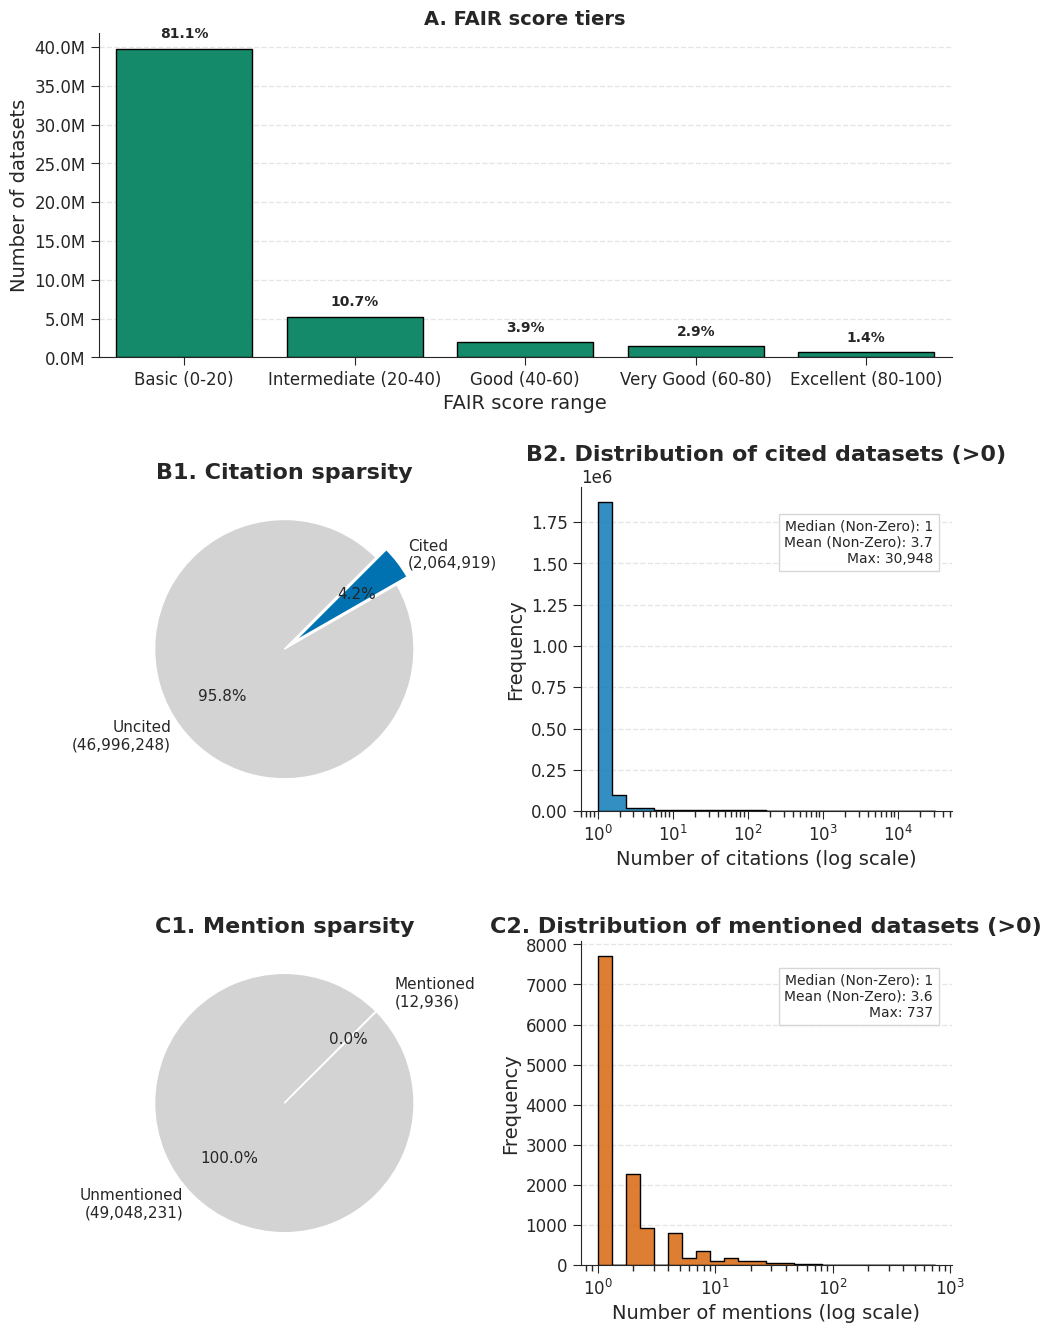

In [116]:
# Pre-processing
bins = [0, 20, 40, 60, 80, 100]
labels = ['Basic (0-20)', 'Intermediate (20-40)', 'Good (40-60)', 'Very Good (60-80)', 'Excellent (80-100)']
df_fair_grouped = df_fair_counts.copy()
df_fair_grouped['Group'] = pd.cut(df_fair_grouped['Score'], bins=bins, labels=labels, right=True)
df_plot_fair = df_fair_grouped.groupby('Group', observed=False)['Count'].sum().reset_index()

# Plot
fig = plt.figure(figsize=(11, 16))
gs = plt.GridSpec(3, 2, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)

# ROW 1: FAIR scores
ax_fair = fig.add_subplot(gs[0, :])

base_rgb = to_rgba(color_palette[0])
fair_colors = [
    (base_rgb[0], base_rgb[1], base_rgb[2], 0.4),
    (base_rgb[0], base_rgb[1], base_rgb[2], 0.55),
    (base_rgb[0], base_rgb[1], base_rgb[2], 0.7),
    (base_rgb[0], base_rgb[1], base_rgb[2], 0.85),
    (base_rgb[0], base_rgb[1], base_rgb[2], 1.0)
]

bars = sns.barplot(
    data=df_plot_fair, 
    x='Group', 
    y='Count', 
    palette=fair_colors, 
    hue='Group', 
    legend=False, 
    edgecolor='black',
    width=0.8,
    dodge=False 
)

ax_fair.set_title('A. FAIR score tiers', fontweight='bold', fontsize=14)
ax_fair.set_xlabel('FAIR score range')
ax_fair.set_ylabel('Number of datasets')
ax_fair.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
ax_fair.grid(axis='y', linestyle='--', alpha=0.5)

total_datasets = df_plot_fair['Count'].sum()
for bar in bars.patches:
    height = bar.get_height()
    if height > 0:
        percentage = (height / total_datasets) * 100
        ax_fair.text(
            bar.get_x() + bar.get_width()/2., 
            height + (total_datasets * 0.02), 
            f'{percentage:.1f}%', 
            ha='center', va='bottom', fontweight='bold'
        )
sns.despine(ax=ax_fair)


# ROW 2: Citations

# Left: Pie Chart
ax_cite_pie = fig.add_subplot(gs[1, 0])
ax_cite_pie.pie(
    [n_zero_c, n_pos_c], 
    labels=[f'Uncited\n({n_zero_c:,})', f'Cited\n({n_pos_c:,})'], 
    autopct='%1.1f%%', 
    colors=['lightgrey', color_palette[1]], 
    explode=(0, 0.1), 
    startangle=45,
    textprops={'fontsize': 11}
)
ax_cite_pie.set_title('B1. Citation sparsity', fontweight='bold')

# Right: Log Histogram 
ax_cite_hist = fig.add_subplot(gs[1, 1])

max_val_c = non_zero_cites.max()
log_bins_c = np.logspace(0, np.log10(max_val_c), 25)

sns.histplot(
    non_zero_cites, 
    bins=log_bins_c, 
    ax=ax_cite_hist, 
    color=color_palette[1], 
    edgecolor='black', 
    alpha=0.8,
    element="step", 
    fill=True
)
ax_cite_hist.set_xscale('log')
ax_cite_hist.set_title('B2. Distribution of cited datasets (>0)', fontweight='bold')
ax_cite_hist.set_xlabel('Number of citations (log scale)')
ax_cite_hist.set_ylabel('Frequency')
ax_cite_hist.grid(axis='y', linestyle='--', alpha=0.5)


median_c = non_zero_cites.median()
mean_c = non_zero_cites.mean()
stats_text_c = (
    f"Median (Non-Zero): {int(median_c)}\n" 
    f"Mean (Non-Zero): {mean_c:.1f}\n"      
    f"Max: {int(non_zero_cites.max()):,}"
)
ax_cite_hist.text(0.95, 0.90, stats_text_c, transform=ax_cite_hist.transAxes, 
                  ha='right', va='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='lightgrey'))
sns.despine(ax=ax_cite_hist)


# ROW 3: Mentions

# Left: Pie Chart
ax_ment_pie = fig.add_subplot(gs[2, 0])
ax_ment_pie.pie(
    [n_zero_m, n_pos_m], 
    labels=[f'Unmentioned\n({n_zero_m:,})', f'Mentioned\n({n_pos_m:,})'], 
    autopct='%1.1f%%', 
    colors=['lightgrey', color_palette[2]], 
    explode=(0, 0.1), 
    startangle=45,
    textprops={'fontsize': 11}
)
ax_ment_pie.set_title('C1. Mention sparsity', fontweight='bold')

# Right: Log Histogram 
ax_ment_hist = fig.add_subplot(gs[2, 1])

max_val_m = non_zero_mentions.max()
log_bins_m = np.logspace(0, np.log10(max_val_m), 25)

sns.histplot(
    non_zero_mentions, 
    bins=log_bins_m, 
    ax=ax_ment_hist, 
    color=color_palette[2], 
    edgecolor='black', 
    alpha=0.8,
    element="step", 
    fill=True
)
ax_ment_hist.set_xscale('log') 
ax_ment_hist.set_title('C2. Distribution of mentioned datasets (>0)', fontweight='bold')
ax_ment_hist.set_xlabel('Number of mentions (log scale)')
ax_ment_hist.set_ylabel('Frequency')
ax_ment_hist.grid(axis='y', linestyle='--', alpha=0.5)

median_m = non_zero_mentions.median()
mean_m = non_zero_mentions.mean()

stats_text_m = (
    f"Median (Non-Zero): {int(median_m)}\n"  
    f"Mean (Non-Zero): {mean_m:.1f}\n"      
    f"Max: {int(non_zero_mentions.max()):,}"
)

ax_ment_hist.text(0.95, 0.90, stats_text_m, transform=ax_ment_hist.transAxes, 
                  ha='right', va='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='lightgrey'))
sns.despine(ax=ax_ment_hist)

# Save
plt.tight_layout()
plt.savefig('output/fair_citations_mentions_distributions.png', dpi=300)
plt.show()

## Distribution of topics and subfields

### Preview table

In [36]:
con = duckdb.connect(dataset_db)
query = """
SELECT *
FROM dataset_metrics
limit 3
"""

display(con.execute(query).df())
con.close()

,dataset_id,pubyear,creators,dataset_source,topic_id,topic_name,topic_score,subfield_id,subfield_name,field_id,...,total_citations,total_cit_weight,cit_3yr,cit_weight_3yr,total_mentions,total_men_weight,men_3yr,men_weight_3yr,raw_dataset_index,raw_dataset_index_3yr
0,10.57451/lhd.ichvolt.88299.1,2024,"[{""name"":""SEKI, Tetsuo"",""name_type"":""Personal""...",datacite,T13769,Fusion and Plasma Physics Studies,0.49,3109,Statistical and Nonlinear Physics,31,...,0,0.00,0,0.00,0,0.00,0,0.00,0.04,0.04
1,10.57451/lhd.ichvolt.88300.1,2024,"[{""name"":""SEKI, Tetsuo"",""name_type"":""Personal""...",datacite,T13769,Fusion and Plasma Physics Studies,0.48,3109,Statistical and Nonlinear Physics,31,...,0,0.00,0,0.00,0,0.00,0,0.00,0.04,0.04
2,10.57451/lhd.ichvolt.88301.1,2024,"[{""name"":""SEKI, Tetsuo"",""name_type"":""Personal""...",datacite,T13769,Fusion and Plasma Physics Studies,0.49,3109,Statistical and Nonlinear Physics,31,...,0,0.00,0,0.00,0,0.00,0,0.00,0.04,0.04


In [37]:
con = duckdb.connect(dataset_db)
schema = con.execute("DESCRIBE dataset_metrics").fetchall()

# Print the schema details
for col in schema:
    print(col)
con.close()

('dataset_id', 'VARCHAR', 'YES', None, None, None)
('pubyear', 'INTEGER', 'YES', None, None, None)
('creators', 'JSON', 'YES', None, None, None)
('dataset_source', 'VARCHAR', 'YES', None, None, None)
('topic_id', 'VARCHAR', 'YES', None, None, None)
('topic_name', 'VARCHAR', 'YES', None, None, None)
('topic_score', 'DOUBLE', 'YES', None, None, None)
('subfield_id', 'VARCHAR', 'YES', None, None, None)
('subfield_name', 'VARCHAR', 'YES', None, None, None)
('field_id', 'VARCHAR', 'YES', None, None, None)
('field_name', 'VARCHAR', 'YES', None, None, None)
('domain_id', 'VARCHAR', 'YES', None, None, None)
('domain_name', 'VARCHAR', 'YES', None, None, None)
('fair_score', 'DOUBLE', 'YES', None, None, None)
('total_citations', 'BIGINT', 'YES', None, None, None)
('total_cit_weight', 'DOUBLE', 'YES', None, None, None)
('cit_3yr', 'BIGINT', 'YES', None, None, None)
('cit_weight_3yr', 'DOUBLE', 'YES', None, None, None)
('total_mentions', 'BIGINT', 'YES', None, None, None)
('total_men_weight', 'DOU

### Number of topics and subfields covered

In [46]:
con = duckdb.connect(dataset_db)
query = "SELECT COUNT(DISTINCT topic_id) FROM dataset_metrics"
unique_topics = con.execute(query).fetchone()[0]
print(f"Unique topics covered in our datasets: {unique_topics}")

query = "SELECT COUNT(DISTINCT subfield_id) FROM dataset_metrics"
unique_subfields = con.execute(query).fetchone()[0]
print(f"Unique topics covered in our datasets: {unique_subfields}")

con.close()

Unique topics covered in our datasets: 4516
Unique topics covered in our datasets: 252


### Frequency of datasets (how many topics/subfileds have 100 dataset, 100 datasets, etc.)

In [92]:
con = duckdb.connect(dataset_db)

topic_df = con.execute("""
    SELECT 
        topic_id,
        ANY_VALUE(topic_name) as topic_name,
        COUNT(dataset_id) as dataset_count
    FROM dataset_metrics
    WHERE topic_id IS NOT NULL  -- Added filter
    GROUP BY topic_id
    ORDER BY dataset_count DESC
""").df()

subfield_df = con.execute("""
    SELECT 
        subfield_id,
        ANY_VALUE(subfield_name) as subfield_name,
        COUNT(dataset_id) as dataset_count
    FROM dataset_metrics
    WHERE subfield_id IS NOT NULL -- Added filter
    GROUP BY subfield_id
    ORDER BY dataset_count DESC
""").df()

print("Top 5 Sufields by Dataset Count:")
print(topic_df.head())

con.close()

Top 5 Sufields by Dataset Count:
  topic_id                               topic_name  dataset_count
0   T13769        Fusion and Plasma Physics Studies       13091682
1   T10597  Nuclear reactor physics and engineering        3194892
2   T10015        Genomics and Phylogenetic Studies        2214406
3   T11854    Laser-induced spectroscopy and plasma        1732322
4   T12157        Geochemistry and Geologic Mapping        1586053


In [95]:
# Topics Frequency
df_topic_dataset_freq = topic_df['dataset_count'].value_counts().reset_index()
df_topic_dataset_freq.columns = ['dataset_count', 'num_topics']
df_topic_dataset_freq = df_topic_dataset_freq.sort_values('dataset_count')

# Subfields Frequency
df_subfield_dataset_freq = subfield_df['dataset_count'].value_counts().reset_index()
df_subfield_dataset_freq.columns = ['dataset_count', 'num_subfields']
df_subfield_dataset_freq = df_subfield_dataset_freq.sort_values('dataset_count')

print("Topic Frequency Distribution (First 5 rows):")
print(df_topic_dataset_freq.head())

Topic Frequency Distribution (First 5 rows):
      dataset_count  num_topics
2595              6           1
504               9           3
1002             10           2
2594             11           1
503              12           3


In [98]:
df_topic_dataset_freq.to_csv('output/topics_frequency.csv')

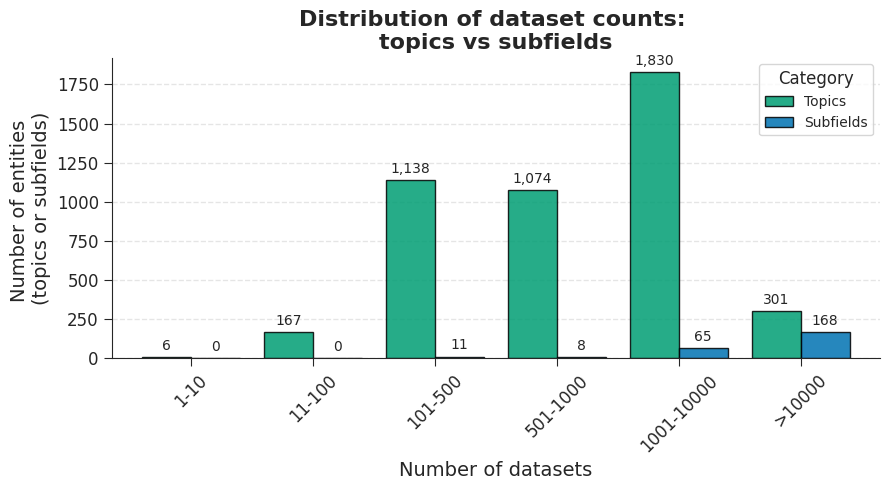

In [118]:
# Bins and labels
bins = [0, 10, 100, 500, 1000, 10000, float('inf')]
labels = ['1-10', '11-100', '101-500', '501-1000', '1001-10000', '>10000']

# Range column for both dfs
topic_df['dataset_range'] = pd.cut(topic_df['dataset_count'], bins=bins, labels=labels)
subfield_df['dataset_range'] = pd.cut(subfield_df['dataset_count'], bins=bins, labels=labels)

# Counts for each range
topic_counts = topic_df['dataset_range'].value_counts().sort_index()
subfield_counts = subfield_df['dataset_range'].value_counts().sort_index()

# Combine into a one df for plotting
df_combined = pd.DataFrame({
    'Topics': topic_counts,
    'Subfields': subfield_counts
})

# Bar chart
ax = df_combined.plot(kind='bar', 
                      figsize=(9, 5), 
                      width=0.8, 
                      color=color_palette, 
                      alpha = 0.85,
                      edgecolor='black')

# Bar labels
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', padding=3)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Formatting
plt.title('Distribution of dataset counts: \ntopics vs subfields')
plt.xlabel('Number of datasets')
plt.ylabel('Number of entities \n(topics or subfields)')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()

# Save
plt.savefig('output/distribution_topics_subfields_dataset_counts.png', dpi=300)
plt.show()

## Dataset Index

## S-index